<a href="https://colab.research.google.com/github/phamnguyenlongvu/Computer-Vision/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Họ và tên: Phạm Nguyễn Long Vũ

Dataset: https://drive.google.com/file/d/1lB2YAWEjiljPsEadCOM7dY4P2fTivZY7/view?usp=share_link

Dữ liệu về ảnh của máy bay: https://www.robots.ox.ac.uk/~vgg/data/bicos/ với 800 ảnh, được chia thành hai tập train, test với tỉ lệ 80:20

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!tar -xvf "/content/gdrive/MyDrive/airplanes.tar"

airplanes/
airplanes/set.mat
airplanes/jpg/
airplanes/jpg/image_00684.jpg
airplanes/jpg/image_00735.jpg
airplanes/jpg/image_00174.jpg
airplanes/jpg/image_00113.jpg
airplanes/jpg/image_00173.jpg
airplanes/jpg/image_00208.jpg
airplanes/jpg/image_00045.jpg
airplanes/jpg/image_00472.jpg
airplanes/jpg/image_00135.jpg
airplanes/jpg/image_00658.jpg
airplanes/jpg/image_00588.jpg
airplanes/jpg/image_00785.jpg
airplanes/jpg/image_00188.jpg
airplanes/jpg/image_00083.jpg
airplanes/jpg/image_00490.jpg
airplanes/jpg/image_00336.jpg
airplanes/jpg/image_00251.jpg
airplanes/jpg/image_00473.jpg
airplanes/jpg/image_00097.jpg
airplanes/jpg/image_00011.jpg
airplanes/jpg/image_00555.jpg
airplanes/jpg/image_00231.jpg
airplanes/jpg/image_00238.jpg
airplanes/jpg/image_00521.jpg
airplanes/jpg/image_00036.jpg
airplanes/jpg/image_00388.jpg
airplanes/jpg/image_00411.jpg
airplanes/jpg/image_00201.jpg
airplanes/jpg/image_00144.jpg
airplanes/jpg/image_00772.jpg
airplanes/jpg/image_00606.jpg
airplanes/jpg/image_00437.

# Import lib

In [3]:
import os
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import display_html

# Dataset

In [4]:
label2color = {
    0: ("Foreground", [150, 150, 150]),
    1: ("Background", [50, 50, 50]),
    2: ("Others:", [255, 255, 255]),
    "FP": ("False Positive", [255, 0, 0]),
    "FN": ("False Negative", [0, 0, 255]),
}

class AirplaneDataset(object):
    def __init__(self, image_path=None, label_path=None, img2label=None, label2color=label2color):
        self.__image_path = image_path
        self.__label_path = label_path
        self.__img2label = img2label
        self.__label2color = label2color

    def update_img2label(self, img2label):
        self.__img2label = img2label

    def update(self):
        image_files = [os.path.join(self.__image_path, name) for name in sorted(os.listdir(self.__image_path))]
        label_files = [os.path.join(self.__label_path, name) for name in sorted(os.listdir(self.__label_path))]
        self.__img2label = dict(zip(image_files, label_files))
        return self

    def __len__(self):
        if(self.__img2label is None):
            raise Exception("Dataset is't valid")

        else: 
            return len(self.__img2label.keys())

    def get_img2label(self):
        return self.__img2label

    def train_test_split(self, test_size = 0.2, random_state=2703):
        files = list(self.__img2label.keys())
        random.Random(random_state).shuffle(files)

        ntests = int(len(files)*test_size)
        train_image = files[:-ntests]
        train_label = [self.__img2label[k] for k in train_image]
        test_image = files[-ntests:]
        test_label = [self.__img2label[k] for k in test_image]

        train_set = AirplaneDataset()
        train_set.update_img2label(dict(zip(train_image, train_label)))
        test_set = AirplaneDataset()
        test_set.update_img2label(dict(zip(test_image, test_label)))
        return train_set, test_set

    def sample(self, nsample=6):
        img = random.sample(list(self.__img2label.keys()), nsample)
        label = [self.__img2label[k] for k in img]
        return img, label

    def load_image(self, img_files, label_files, shape=(256, 256), colorized=True):
        imgs, labels = [], []
        for k in range(len(img_files)):
            if shape is not None:
                image = np.asarray(utils.load_img(img_files[k], target_size=shape, color_mode='rgb'))
                label = np.asarray(utils.load_img(label_files[k], target_size=shape, color_mode='grayscale'))
            else: 
                image = np.asarray(utils.load_img(img_files[k], color_mode='rgb'))
                label = np.asarray(utils.load_img(label_files[k], color_mode='grayscale'))

            image = image/255
            label = label/255

            imgs.append(image)
            labels.append(label)

        if colorized:
            color_labels = []
            for label in labels:
                color_label = np.zeros((*label.shape, 3), dtype=np.uint8)
                for k in self.__label2color.keys():
                    color_label[label == k] = self.__label2color[k][1]
                    
                color_labels.append(color_label)
            labels = color_labels

        return imgs, labels

    def visualize(self, nsample=1, shape=None):
        img, label = self.sample(nsample)
        imgs, labels = self.load_image(img, label)

        fig = plt.figure(figsize=(12, 12))
        for k in range(len(img)):
            ax = plt.subplot(nsample, 2, 2*k + 1)
            ax.imshow(imgs[k])
            ax.set_title(img[k].split('/')[-1])
            ax.set_axis_off()

            ax = plt.subplot(nsample, 2, 2*k + 2)
            ax.imshow(labels[k])
            ax.set_title(label[k].split('/')[-1])
            ax.set_axis_off()


        plt.show()

            

In [5]:
image_path = "/content/airplanes/jpg"
label_path = "/content/airplanes/gt"

In [6]:
Ds = AirplaneDataset(image_path, label_path)
Ds.update()
train_set, test_set = Ds.train_test_split()

<ipython-input-4-2fc14fa3a158>:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  color_label[label == k] = self.__label2color[k][1]


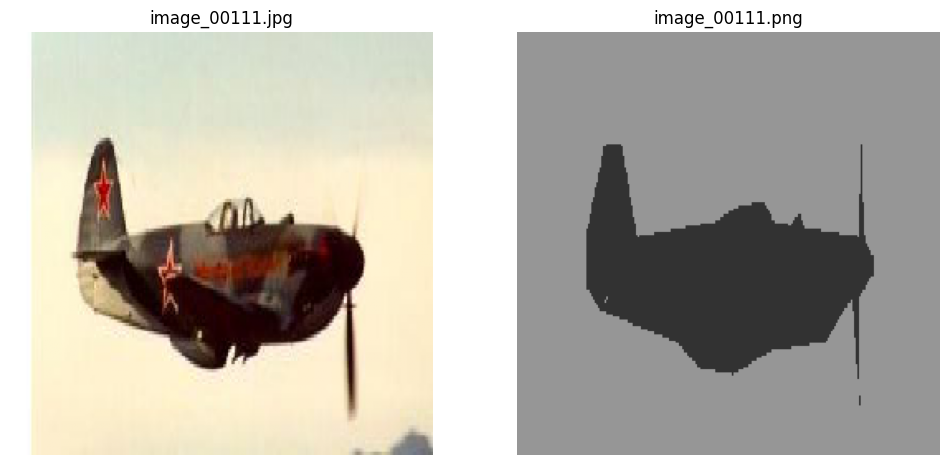

In [7]:
Ds.visualize()

# Data Loader

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

class DataLoader(keras.utils.Sequence):
    def __init__(self, dataset, batch_size=32, image_size=(256, 256), shuffle=True):
        self.__dataset = dataset
        self.__batch_size = batch_size
        self.__image_size = image_size
        self.__image2label = dataset.get_img2label()
        self.__prepare(shuffle)
        self.__image_gen = ImageDataGenerator(**data_gen)
        self.__label_gen = ImageDataGenerator(**data_gen)

    def __prepare(self, shuffle=True):
        self.__image_files=list(self.__image2label.keys())
        if shuffle:
            self.__image_files=random.sample(self.__image_files, len(self.__image_files))
    
    def __len__(self):
       return len(self.__dataset) // self.__batch_size

    def __getitem__(self, batch_idx):
        start_idx = batch_idx * self.__batch_size
        end_idx = min(start_idx + self.__batch_size, len(self.__image_files)-1)
        fn_images = self.__image_files[start_idx:end_idx]
        fn_labels = [self.__image2label[k] for k in fn_images]
        images, labels = self.__dataset.load_image(fn_images, fn_labels, shape=self.__image_size, colorized=False)

        labels = [np.expand_dims(label, axis=-1) for label in labels]
        
        images = np.concatenate([np.expand_dims(image, axis=0) for image in images], axis=0)
        labels = np.concatenate([np.expand_dims(label, axis=0) for label in labels], axis=0)

        # images = [np.expand_dims(image, axis=0) for image in images]
        # labels = [np.expand_dims(label, axis=0) for label in labels]
        # Augmentation
        # images = self.__image_gen.fit(images, seed=1)
        # labels = self.__label_gen.fit(labels, seed=1)
        
        return images, labels

In [9]:
image_size = (128, 128)
num_classes = 3

# Show Different

In [10]:
def threshould(label, predicted):
    label[label < 0.5] = 0
    label[label >= 0.5] = 1

    predicted[predicted < 0.5] = 0
    predicted[predicted >= 0.5] = 1
    
    return label, predicted

def show_result(img, gt, predicted):
    without_ths = predicted

    gt, predicted = threshould(gt, predicted)

    h, w = gt.shape
    mask = np.zeros((h, w, 3), np.uint8)
    false_positive = (predicted == 1) & (gt == 0)
    mask[false_positive] = label2color['FP'][1]

    background = (predicted == 0) & (gt == 0)
    mask[background] = label2color[1][1]

    foreground = (predicted == 1) & (gt == 1)
    mask[foreground] = label2color[0][1]

    false_negative = (predicted == 0) & (gt == 1)
    mask[false_negative] = label2color['FN'][1]
    imgs = [img, gt, without_ths, predicted, mask]
    titles = ['Image', 'Ground true', 'Without threshould', 'Predicted', 'Result']

    fig = plt.figure(figsize=(12, 12))
    for k in range(len(imgs)):
        ax = plt.subplot(5, 1, k+1)
        ax.set_axis_off()
        ax.set_title(titles[k])
        ax.imshow(imgs[k])

    plt.show()

In [11]:
def plot_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'k--.')
    plt.plot(history.history['val_loss'], 'k--*')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')

    plt.subplot(1, 2, 2)
    plt.plot(np.array(history.history['accuracy'])*100, 'k--.')
    plt.plot(np.array(history.history['val_accuracy'])*100, 'k--*')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')

    plt.show()

# Metrics



*   IoU là phương pháp đánh giá kết quả phân đoạn ảnh. IoU được tính bằng tỉ lệ diện tích phần giao giữa kết quả và nhãn đúng với diện tích phần hợp của hai vùng đó. Kết quả IoU càng cao, mô hình phân đoạn càng tốt. 
*   Dice Score là một phương pháp đánh giá độ tương đồng giữa hai vùng ảnh hoặc đối tượng đưuọc tính bằng tỉ lệ giữa diện tích phần ching và tổng diện tích giữa hai vùng đó. Kết quả Dice Score càng cao, độ chính xác của mô hình phân đoạn càng tốt. 



In [30]:
from tensorflow.keras import backend as K

def iou_score(labels, preds):
    i, u = 0, 0
    for label, pred in zip(labels, preds):
        label = np.array(label)
        pred = np.array(pred)
        label, pred = threshould(label, pred)
        intersection = K.sum(label*pred)
        union = K.sum(label+pred) - intersection
        i += intersection
        u += union
    return i/u

def dice_score(labels, preds):
    i, t = 0, 0
    for label, pred in zip(labels, preds):
        label = np.array(label)
        pred = np.array(pred)
        label, pred = threshould(label, pred)
        intersection = K.sum(label*pred)
        total = K.sum(pred) + K.sum(label)
        i += intersection
        t += total
    return 2.*i / t

# Unet

In [13]:
def upsampling(X, skip):
    X = layers.UpSampling2D((2, 2))(X)
    return layers.Concatenate()([X, skip])

def Unet_simple(input):
    X_input = layers.Input(input)

    # Stage 1
    conv_1 = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(X_input)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
    conv_1 = layers.BatchNormalization()(conv_1)
    pooling_1 = layers.MaxPooling2D((2, 2))(conv_1)

    # Stage 2
    conv_2 = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pooling_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_2 = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_2)
    conv_2 = layers.BatchNormalization()(conv_2)
    pooling_2 = layers.MaxPooling2D((2, 2))(conv_2)

    # Stage 3
    conv_3 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pooling_2)
    conv_3 = layers.BatchNormalization()(conv_3)
    conv_3 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_3)
    conv_3 = layers.BatchNormalization()(conv_3)
    pooling_3 = layers.MaxPooling2D((2, 2))(conv_3)

    # Stage 4
    conv_4 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pooling_3)
    conv_4 = layers.BatchNormalization()(conv_4)
    conv_4 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_4)
    conv_4 = layers.BatchNormalization()(conv_4)
    pooling_4 = layers.MaxPooling2D((2, 2))(conv_4)

    # Stage 5 (Bottle neck)
    conv_5 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pooling_4)
    conv_5 = layers.BatchNormalization()(conv_5)
    conv_5 = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_5)
    conv_5 = layers.BatchNormalization()(conv_5)

    # Upsample stage 1
    up_1 = upsampling(conv_5, conv_4)
    up_1 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_1)
    up_1 = layers.BatchNormalization()(up_1)
    up_1 = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_1)
    up_1 = layers.BatchNormalization()(up_1)

    # Upsample stage 2
    up_2 = upsampling(up_1, conv_3)
    up_2 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_2)
    up_2 = layers.BatchNormalization()(up_2)
    up_2 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_2)
    up_2 = layers.BatchNormalization()(up_2)

    # Upsample stage 3
    up_3 = upsampling(up_2, conv_2)
    up_3 = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_3)
    up_3 = layers.BatchNormalization()(up_3)
    up_3 = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_3)
    up_3 = layers.BatchNormalization()(up_3)

    # Upsample stage 4
    up_4 = upsampling(up_3, conv_1)
    up_4 = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_4)
    up_4 = layers.BatchNormalization()(up_4)
    up_4 = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(up_4)
    up_4 = layers.BatchNormalization()(up_4)

    output = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(up_4)

    model = keras.Model(X_input, output)  
    return model


keras.backend.clear_session()
model_unet = Unet_simple((*image_size, 3))
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
train_loader = DataLoader(train_set, batch_size=16, image_size=image_size)
test_loader = DataLoader(test_set, batch_size=16, image_size=image_size)

optimizer = keras.optimizers.Adam(learning_rate=1e-2)

# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", 
#               metrics=['accuracy'])
model_unet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("u_net_segment.h5", save_best_only=True)
]

epochs = 100
history_unet = model_unet.fit(train_loader, epochs=epochs, validation_data=test_loader, callbacks=cbs)

Epoch 1/100
40/40 [==============================] - 39s 155ms/step - loss: 0.3340 - accuracy: 0.8728 - val_loss: 93443.1094 - val_accuracy: 0.1677
Epoch 2/100
40/40 [==============================] - 4s 90ms/step - loss: 0.1373 - accuracy: 0.9460 - val_loss: 120.3436 - val_accuracy: 0.1793
Epoch 3/100
40/40 [==============================] - 5s 122ms/step - loss: 0.1108 - accuracy: 0.9540 - val_loss: 12.5391 - val_accuracy: 0.3470
Epoch 4/100
40/40 [==============================] - 3s 83ms/step - loss: 0.0971 - accuracy: 0.9597 - val_loss: 1.4543 - val_accuracy: 0.8577
Epoch 5/100
40/40 [==============================] - 3s 81ms/step - loss: 0.0889 - accuracy: 0.9631 - val_loss: 1.3651 - val_accuracy: 0.8326
Epoch 6/100
40/40 [==============================] - 5s 129ms/step - loss: 0.0777 - accuracy: 0.9682 - val_loss: 0.6644 - val_accuracy: 0.8875
Epoch 7/100
40/40 [==============================] - 3s 84ms/step - loss: 0.0752 - accuracy: 0.9690 - val_loss: 0.3199 - val_accuracy: 0.

In [15]:
# Sample image and label from test-set
img_sample, label_sample = test_set.sample(1)
img, label = test_set.load_image(img_sample, label_sample, shape=(128, 128), colorized=False)

img = np.expand_dims(img, axis=0)

# Predict
pred = model_unet.predict(img[0])

1/1 [==============================] - 1s 994ms/step


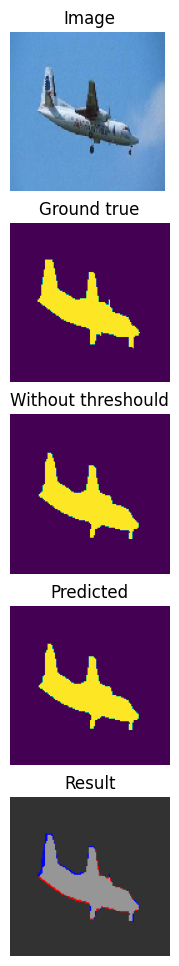

In [16]:
pred = np.squeeze(pred)
img = np.squeeze(img[0])
show_result(img ,label[0], pred)

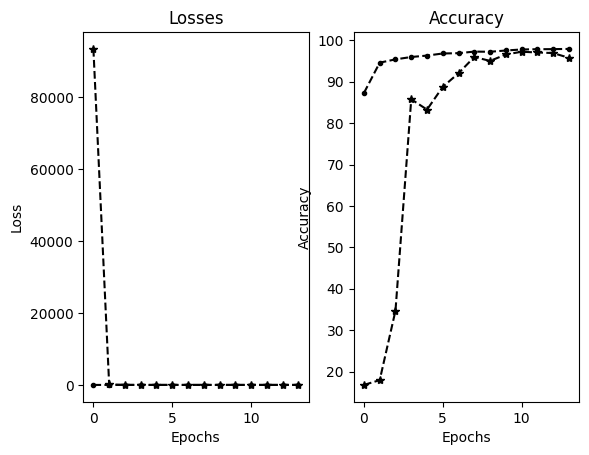

In [17]:
plot_history(history_unet)

In [35]:
ntests = len(test_loader)
total_iou_score = 0
total_dice_score = 0
for batch_img, batch_label in test_loader:
    pred = model_unet(batch_img)
    batch_label, preds = np.squeeze(batch_label), np.squeeze(pred)
    total_iou_score += iou_score(batch_label, preds)

print(total_iou_score / ntests)
# print(total_dice_score/ntests)

tf.Tensor(0.8520077961315341, shape=(), dtype=float64)


# Res-Unet

In [36]:
def Res_block(X, f):
    X_copy = X

    X = layers.Conv2D(f, 1, kernel_initializer="he_normal")(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(f, 3, kernel_initializer="he_normal")(X)
    X = layers.BatchNormalization()(X)

    X_copy = layers.Conv2D(f, 1, kernel_initializer="he_normal")(X_copy)
    X_copy = layers.BatchNormalization()(X_copy)
    X_copy = layers.Dropout(0.5)(X_copy)

    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)

    return X

def Res_Unet(input):
    X_input = layers.Input(input)

    # Stage 1
    conv_1 = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(X_input)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv_1)
    conv_1 = layers.BatchNormalization()(conv_1)
    pooling_1 = layers.MaxPooling2D((2, 2))(conv_1)

    # Stage 2
    conv_2 = Res_block(pooling_1, 32)
    pooling_2 = layers.MaxPooling2D((2, 2))(conv_2)

    # Stage 3
    conv_3 = Res_block(pooling_2, 64)
    pooling_3 = layers.MaxPooling2D((2, 2))(conv_3)

    # Stage 4
    conv_4 = Res_block(pooling_3, 128)
    pooling_4 = layers.MaxPooling2D((2, 2))(conv_4)

    # Stage 5
    conv_5 = Res_block(pooling_4, 256)

    # Up_1
    up_1 = upsampling(conv_5, conv_4)
    up_1 = Res_block(up_1, 128)

    # Up_2
    up_2 = upsampling(up_1, conv_3)
    up_2 = Res_block(up_2, 64)

    # Up_3
    up_3 = upsampling(up_2, conv_2)
    up_3 = Res_block(up_3, 32)

    # Up_4
    up_4 = upsampling(up_3, conv_1)
    up_4 = Res_block(up_4, 16)

    output = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(up_4)

    model = keras.Model(inputs=X_input, outputs=output)

    return model

keras.backend.clear_session()
model_runet = Unet_simple((*image_size, 3))
model_runet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [37]:
train_loader = DataLoader(train_set, batch_size=16, image_size=image_size)
test_loader = DataLoader(test_set, batch_size=16, image_size=image_size)

optimizer = keras.optimizers.Adam(learning_rate=1e-2)

# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", 
#               metrics=['accuracy'])
model_runet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("ru_net_segment.h5", save_best_only=True)
]

epochs = 100
history_runet = model_runet.fit(train_loader, epochs=epochs, validation_data=test_loader, callbacks=cbs)

Epoch 1/100
40/40 [==============================] - 20s 105ms/step - loss: 0.3392 - accuracy: 0.8614 - val_loss: 29799.9648 - val_accuracy: 0.1676
Epoch 2/100
40/40 [==============================] - 4s 105ms/step - loss: 0.1340 - accuracy: 0.9457 - val_loss: 253.6368 - val_accuracy: 0.1992
Epoch 3/100
40/40 [==============================] - 4s 102ms/step - loss: 0.1019 - accuracy: 0.9590 - val_loss: 21.7512 - val_accuracy: 0.3137
Epoch 4/100
40/40 [==============================] - 3s 71ms/step - loss: 0.0988 - accuracy: 0.9596 - val_loss: 1.3805 - val_accuracy: 0.7771
Epoch 5/100
40/40 [==============================] - 2s 62ms/step - loss: 0.0812 - accuracy: 0.9669 - val_loss: 1.6126 - val_accuracy: 0.8156
Epoch 6/100
40/40 [==============================] - 4s 90ms/step - loss: 0.0723 - accuracy: 0.9706 - val_loss: 0.1844 - val_accuracy: 0.9483
Epoch 7/100
40/40 [==============================] - 4s 92ms/step - loss: 0.0648 - accuracy: 0.9736 - val_loss: 0.2151 - val_accuracy: 0.

In [38]:
# Sample image and label from test-set
img_sample, label_sample = test_set.sample(1)
img, label = test_set.load_image(img_sample, label_sample, shape=(128, 128), colorized=False)

img = np.expand_dims(img, axis=0)

# Predict
pred = model_runet.predict(img[0])

1/1 [==============================] - 0s 155ms/step


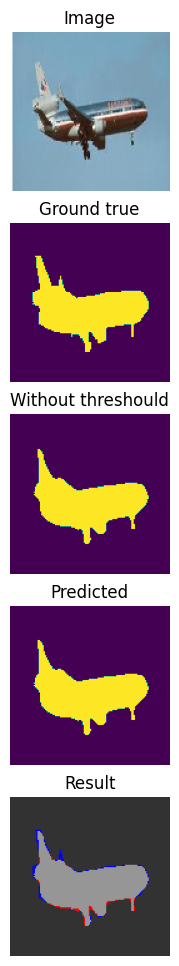

In [39]:
pred = np.squeeze(pred)
img = np.squeeze(img[0])
show_result(img ,label[0], pred)

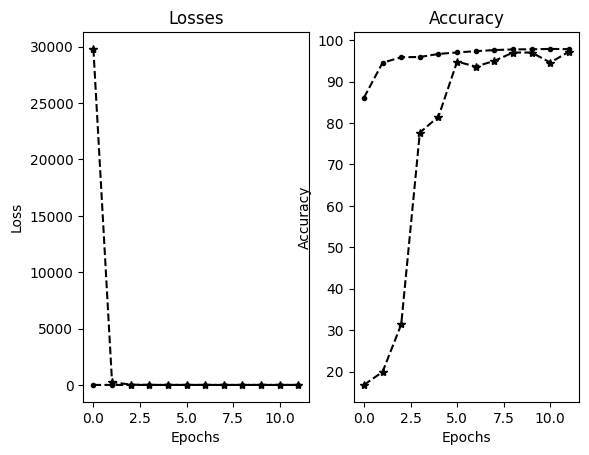

In [40]:
plot_history(history_runet)

In [41]:
ntests = len(test_loader)
total_iou_score = 0
total_dice_score = 0
for batch_img, batch_label in test_loader:
    pred = model_runet(batch_img)
    batch_label, preds = np.squeeze(batch_label), np.squeeze(pred)
    total_iou_score += iou_score(batch_label, preds)

print(total_iou_score / ntests)

tf.Tensor(0.8364537136120849, shape=(), dtype=float64)



# Compare

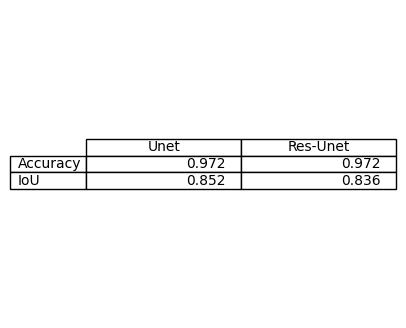

In [43]:
import pandas as pd

Unet = {'Accuracy': 0.972, 'IoU': 0.852}
Res_Unet = {'Accuracy': 0.972, 'IoU': 0.836}

df = pd.DataFrame({'Unet':Unet, 'Res-Unet': Res_Unet})
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
plt.show()

Kết quả của mô hình Unet tốt hơn so với Res-Unet. Mặc dù Res-Unet kết hợp sử dụng Residual block để tránh mất mát thông tin, nhưng lại không hiệu quả. Có thể do dữ liệu huấn luyện quá ít.